In [1]:
# Import libraries needed in this research
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from pylab import figure, axes, pie, title, savefig

In [2]:
# cross validations to find the ideal parameter for C and epsilon. 
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    epsilons = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'epsilon' : epsilons}
    grid_search = GridSearchCV(LinearSVR(fit_intercept=False), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [3]:
# Read NBER(2006) patent data 
FirmInfo     = pd.read_stata("nber data/NBER_US_public_firm_assignee.dta")
ClassInfo    = pd.read_stata("nber data/3930271_8341762_class.dta")
YearInfo     = pd.read_stata("nber data/3930271_7155745_date.dta")

In [4]:
# Merge FirmInfo and ClassInfo, on WKU.
FirmInfo_class = pd.merge(FirmInfo, ClassInfo[["wku","cat_code"]], how="left", on="wku")
#FirmInfo_class.head(20)

In [5]:
# Group FirmInfo on gvkey, filed_year and cat_code. The counts are stored into the wku. 
FirmInfo_class_agg = FirmInfo_class[["gvkey","filed_year","cat_code","wku"]].groupby(["gvkey","filed_year","cat_code"], as_index=False).count()
#FirmInfo_class_agg.head(20)

In [6]:
# create a mapper for the preparation of expanding the dataset into a dataset with all six categories in each year.
Mapper = [[k, i, j] for k in FirmInfo_class_agg.gvkey.unique() for i in range(1976, 2007) for j in range(1,7)]
Mapper = pd.DataFrame(Mapper, columns = ["gvkey", "filed_year","cat_code"])

In [7]:
# Change the data type of the mapper as int
Mapper.filed_year = Mapper.filed_year.astype(int)
Mapper.cat_code = Mapper.cat_code.astype(int)
Mapper.gvkey = Mapper.gvkey.astype(int)
#Mapper.head(10)

In [8]:
# Change the data type of the FirmInfo_class_agg as int
FirmInfo_class_agg.gvkey = FirmInfo_class_agg.gvkey.astype(int)
FirmInfo_class_agg.filed_year = FirmInfo_class_agg.filed_year.astype(int)
FirmInfo_class_agg.cat_code = FirmInfo_class_agg.cat_code.astype(int)
FirmInfo_class_agg.wku = FirmInfo_class_agg.wku.astype(int)

In [9]:
# Merge FirmInfo_class_agg and Mapper, on gvkey, filed_year, cat_code. If there is any NULL value, filled it with zero.
FirmInfo_class_agg_full = pd.merge(Mapper, FirmInfo_class_agg, how="left", on=["gvkey","filed_year","cat_code"]).fillna(0)


In [10]:
# Sort the values in FirmInfo_class_agg_full ascendingly
FirmInfo_class_agg_full = FirmInfo_class_agg_full.sort_values(["gvkey","cat_code","filed_year"])
#FirmInfo_class_agg_full.head(10)

In [11]:
# FirmInfo_class_agg_full["wku"] = np.log(FirmInfo_class_agg_full["wku"]+1)

In [12]:
# Create 8 lag variable for file year/class/patent id/firm id. It is a shifting technique.
for i in range(1,8):
    FirmInfo_class_agg_full["filed_year_"+str(i)] = FirmInfo_class_agg_full["filed_year"].shift(i)
    FirmInfo_class_agg_full["cat_code_"+str(i)] = FirmInfo_class_agg_full["cat_code"].shift(i)
    FirmInfo_class_agg_full["wku_"+str(i)] = FirmInfo_class_agg_full["wku"].shift(i)
    FirmInfo_class_agg_full["gvkey_"+str(i)] = FirmInfo_class_agg_full["gvkey"].shift(i)
#FirmInfo_class_agg_full.head(30)

In [13]:
# The and operation applied here is tring to make sure each record/row have no Nah values,
# which means to make sure the input feature matrix for the later prediction has no Nahs.
FirmInfo_class_agg_full_save_for_update = FirmInfo_class_agg_full
FirmInfo_class_agg_full = FirmInfo_class_agg_full[(FirmInfo_class_agg_full.gvkey==FirmInfo_class_agg_full.gvkey_1)& \
                                                  (FirmInfo_class_agg_full.gvkey==FirmInfo_class_agg_full.gvkey_2)& \
                                                  (FirmInfo_class_agg_full.gvkey==FirmInfo_class_agg_full.gvkey_3)& \
                                                  (FirmInfo_class_agg_full.gvkey==FirmInfo_class_agg_full.gvkey_4)& \
                                                  (FirmInfo_class_agg_full.gvkey==FirmInfo_class_agg_full.gvkey_5)& \
                                                  (FirmInfo_class_agg_full.gvkey==FirmInfo_class_agg_full.gvkey_6)& \
                                                  (FirmInfo_class_agg_full.gvkey==FirmInfo_class_agg_full.gvkey_7)& \
                                                  (FirmInfo_class_agg_full.cat_code==FirmInfo_class_agg_full.cat_code_1)& \
                                                  (FirmInfo_class_agg_full.cat_code==FirmInfo_class_agg_full.cat_code_2)& \
                                                  (FirmInfo_class_agg_full.cat_code==FirmInfo_class_agg_full.cat_code_3)& \
                                                  (FirmInfo_class_agg_full.cat_code==FirmInfo_class_agg_full.cat_code_4)& \
                                                  (FirmInfo_class_agg_full.cat_code==FirmInfo_class_agg_full.cat_code_5)& \
                                                  (FirmInfo_class_agg_full.cat_code==FirmInfo_class_agg_full.cat_code_6)& \
                                                  (FirmInfo_class_agg_full.cat_code==FirmInfo_class_agg_full.cat_code_7)& \
                                                  (FirmInfo_class_agg_full.filed_year==FirmInfo_class_agg_full.filed_year_1+1)& \
                                                  (FirmInfo_class_agg_full.filed_year==FirmInfo_class_agg_full.filed_year_2+2)& \
                                                  (FirmInfo_class_agg_full.filed_year==FirmInfo_class_agg_full.filed_year_3+3)& \
                                                  (FirmInfo_class_agg_full.filed_year==FirmInfo_class_agg_full.filed_year_4+4)& \
                                                  (FirmInfo_class_agg_full.filed_year==FirmInfo_class_agg_full.filed_year_5+5)& \
                                                  (FirmInfo_class_agg_full.filed_year==FirmInfo_class_agg_full.filed_year_6+6)& \
                                                  (FirmInfo_class_agg_full.filed_year==FirmInfo_class_agg_full.filed_year_7+7)]


#FirmInfo_class_agg_full.head(10)

In [14]:
# we only use the former six year's wku information. Here we select them.
FirmInfo_class_agg_full_clean1=FirmInfo_class_agg_full[["gvkey","filed_year","cat_code","wku","wku_1","wku_2","wku_3","wku_4","wku_5","wku_6"]]
#FirmInfo_class_agg_full_clean1.head(10)

In [15]:
# FirmInfo_class_agg_full_clean1.to_csv("Patent_ML_Inputs.csv", index=False)

In [16]:
# create a six column feature matrix in cat_code. This step is used to transform the cat_code.
DummyClass = pd.get_dummies(FirmInfo_class_agg_full_clean1.cat_code)
#DummyClass.head(40)

In [17]:
# construct the clean input feature matrix with "six year's wku" FirmInfo_class_agg_full_clean1 and
# six category code.
FirmInfo_class_agg_full_clean1 = pd.concat([FirmInfo_class_agg_full_clean1, DummyClass], axis=1)
#FirmInfo_class_agg_full_clean1.head(40)

In [18]:
FirmInfo_class_agg_full_clean1.columns=[     u'gvkey', u'filed_year',   u'cat_code',        u'wku',
                                             u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
                                             u'wku_5',      u'wku_6',      'cat_code1',  'cat_code2',  'cat_code3',
                                             'cat_code4',  'cat_code5',  'cat_code6']

In [19]:
# Here we include additional features calculated by another source.
#print FirmInfo_class_agg_full_clean1.shape
AddionalFeatures = pd.read_csv("regressions/firm characters/TEMP1.csv")
AddionalFeatures.rename(columns={'year':'filed_year'}, inplace=True)
#print AddionalFeatures.head(10)
FirmInfo_class_agg_full_clean1 = pd.merge(FirmInfo_class_agg_full_clean1, AddionalFeatures, how="left", on=["gvkey","filed_year"]).fillna(0)


In [20]:
# Divide the input feature matrix before 2001 (trainning) and after 2001 (testing)
syear = 2001
FirmInfo_class_agg_full_clean1_test = FirmInfo_class_agg_full_clean1[FirmInfo_class_agg_full_clean1.filed_year<=syear]
FirmInfo_class_agg_full_clean1_pred = FirmInfo_class_agg_full_clean1[FirmInfo_class_agg_full_clean1.filed_year>syear]


In [21]:

###Uwith Additional features
X = FirmInfo_class_agg_full_clean1_test[[u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
                                         u'wku_5',      u'wku_6',     'cat_code1',  'cat_code2',  'cat_code3',
                                         'cat_code4',  'cat_code5',  'cat_code6',"w_rd2sale","w_M2B","w_LOG_SIZE","w_roa","w_lev","w_spread","log_state_patents","log_class_patents"]].values
Y = FirmInfo_class_agg_full_clean1_test[["wku"]].values

X_pred = FirmInfo_class_agg_full_clean1_pred[[u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
                                         u'wku_5',      u'wku_6', 'cat_code1',  'cat_code2',  'cat_code3',
                                         'cat_code4',  'cat_code5',  'cat_code6',"w_rd2sale","w_M2B","w_LOG_SIZE","w_roa","w_lev","w_spread","log_state_patents","log_class_patents"]].values
X_ind  = FirmInfo_class_agg_full_clean1_pred[["gvkey","filed_year","cat_code"]].values


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#SelectModel = SelectKBest(f_classif, k='all')
SelectModel = SelectKBest(f_classif, k=10)
X = SelectModel.fit_transform(X, Y)
X_pred = SelectModel.transform(X_pred)

##Get Selected Features
feature_names = [u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
                                         u'wku_5',      u'wku_6', 'cat_code1',  'cat_code2',  'cat_code3',
                                         'cat_code4',  'cat_code5',  'cat_code6',"w_rd2sale","w_M2B","w_LOG_SIZE","w_roa","w_lev","w_spread","log_state_patents","log_class_patents"]
mask = SelectModel.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
print new_features

/home/yuansun/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[u'wku_1', u'wku_2', u'wku_3', u'wku_4', u'wku_5', u'wku_6', 'w_rd2sale', 'w_M2B', 'w_LOG_SIZE', 'w_spread']


In [22]:

# #####No additional features
# X = FirmInfo_class_agg_full_clean1_test[[u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
#                                          u'wku_5',      u'wku_6',     'cat_code1',  'cat_code2',  'cat_code3',
#                                          'cat_code4',  'cat_code5',  'cat_code6']].values
# Y = FirmInfo_class_agg_full_clean1_test[["wku"]].values

# X_pred = FirmInfo_class_agg_full_clean1_pred[[u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
#                                          u'wku_5',      u'wku_6', 'cat_code1',  'cat_code2',  'cat_code3',
#                                          'cat_code4',  'cat_code5',  'cat_code6']].values
# X_ind  = FirmInfo_class_agg_full_clean1_pred[["gvkey","filed_year","cat_code"]].values


In [23]:
#svc_param_selection(X,Y,3)

In [24]:
#print len(X_pred)

In [25]:
## Linear SVM Model
clf = LinearSVR(C = 0.01, epsilon=0.01)
clf.fit(X, Y)

### Lasso Model
# from sklearn import linear_model
# clf = linear_model.Lasso(alpha=0.1)
# clf.fit(X, Y)

### Ridge Model
# from sklearn import linear_model
# clf = linear_model.Ridge(alpha=1.0)
# clf.fit(X, Y)


# Neural Network Model
# from sklearn.neural_network import MLPRegressor
# clf = MLPRegressor(
#     hidden_layer_sizes=(15,),  activation='relu', solver='lbfgs', alpha=0.001, batch_size='auto',
#     learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
#     random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
#     early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08).fit(X, Y)

##  Decision Tree Model
# from sklearn import tree
# clf = tree.DecisionTreeRegressor().fit(X, Y)

# ##Logistic Regression Model (slow)
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0, solver='newton-cg',
#                           multi_class='multinomial').fit(X, Y)

##Random Forest Classifier Model
# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(n_estimators = 100,random_state=0).fit(X, Y)


/home/yuansun/.local/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=0.01, dual=True, epsilon=0.01, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [26]:
#### forward prediction propagation.
#### The purpose of this step is to predict to patent number year by year. The key idea here
### is to use predicted patent number as the input for the next year's patent number prediction.
#### The commented area are leave behind on purpose. Uncommented them would help you understand
#### this step.

#X_pred = FirmInfo_class_agg_full_clean1_pred[[u'wku_1',      u'wku_2',      u'wku_3',      u'wku_4',
#                                         u'wku_5',      u'wku_6', 'cat_code1',  'cat_code2',  'cat_code3',
#                                         'cat_code4',  'cat_code5',  'cat_code6']].head(200).values


firm = 1004
year = syear
cat_code = 1
outputs = []

for i in range(len(X_pred)):
    #print ("i:", i)
    #print("firm,year,cat_code before", firm,year,cat_code)
    #print ("X_ind[i]", X_ind[i],"X_ind[i+1]", X_ind[i+1])
    #print ("???X_pred[i]:", X_pred[i],"???X_pred[i+1]:", X_pred[i+1])
    #rY = svr_lin.predict([X_pred[i]])
    rY = clf.predict([X_pred[i]])
    
    #print ("rY:", rY)
    #print ("!!!X_pred[i]:", X_pred[i],"!!!X_pred[i+1]:", X_pred[i+1])
    if (X_ind[i][0]==firm)&((X_ind[i][1]-year)==1)&(X_ind[i][2]==cat_code)&(X_ind[i][1]<2006):
        update_list = list(X_pred[i])
        update_list.insert(0, rY[0])
        X_pred[i+1][0:6] = update_list[0:6]
        #print "I am in update"
    #else:
        #print "I am not in update"
    firm = X_ind[i][0]
    year = X_ind[i][1]
    cat_code = X_ind[i][2]
    if (X_ind[i][1]==2006)&(i<len(X_pred)-1):
        firm = X_ind[i+1][0]
        year = syear
        cat_code = X_ind[i+1][2]
        #print "I am in 2006, boundary, reset"
    else:
        firm = X_ind[i][0]
        year = X_ind[i][1]
        cat_code = X_ind[i][2]
        #print "I am NOT in 2006, keep going"
    
    outputs+=[[X_ind[i][0], X_ind[i][1], X_ind[i][2], rY[0]]]

    #print ("X_pred[i]:", X_pred[i],"X_pred[i+1]:", X_pred[i+1])
    #print ("firm,year,cat_code after", firm,year,cat_code)
    #print ("")
    #print ("")
    #print (outputs)

In [27]:
## sim contains the predictions. Here group the prediction by gvkey and year, and sum the predictions for all the classes.
MLoutputs = pd.DataFrame(outputs, columns = ["gvkey","year","class","sim"])
#print MLoutputs.head(30)
# MLoutputs["sim"] = np.exp(MLoutputs.sim)-1
MLoutputs_agg = MLoutputs[["gvkey","year","sim"]].groupby(["gvkey","year"], as_index=False).sum()
#print MLoutputs_agg.head(30)

In [28]:
MLoutputs_agg.to_csv("outputs3.csv")

In [29]:
# Now we prepare the comparing dataset (NBER 2006 and our data).
Comp = pd.read_csv("outputs3.csv")
Full_data = pd.read_stata("regressions/construct bias/final_patent_citation_data.dta")
#print Full_data.head(10)

In [30]:
## number_of_patent_o means our data, while number_of_patent_n means NBER 2006 data
Compare_res = pd.merge(MLoutputs_agg, Full_data[["gvkey", "year", "number_of_patent_o", "number_of_patent_n"]], 
                       how="left", on=["gvkey","year"]).fillna(0)
#print Compare_res.head(10)

In [31]:
## if sim (prediction) is less than zero, we assigned zero because the counts can not be negative.
Compare_res.loc[Compare_res.sim<0,"sim"] = 0

In [32]:
# Now rename the final comparing results.
Compare_res.columns=[u'gvkey', u'year', u'Predicted Patent Number', u'Our Data Patent Number',
       u'NBER2006 Patent Number']
#print Compare_res.head(10)

In [33]:
####Compare them by correlation, RMSE, MAE and R squared.
print "Prediction correlation: "
print Compare_res["Our Data Patent Number"].corr(Compare_res["Predicted Patent Number"])
print "NBER 2006 correlation: "
print Compare_res["Our Data Patent Number"].corr(Compare_res["NBER2006 Patent Number"])

from sklearn.metrics import mean_squared_error
print "Prediction RMSE: "
print np.sqrt(mean_squared_error(Compare_res["Our Data Patent Number"].values, Compare_res["Predicted Patent Number"].values))
print "NBER 2006 RMSE: "
print np.sqrt(mean_squared_error(Compare_res["Our Data Patent Number"].values, Compare_res["NBER2006 Patent Number"].values))

from sklearn.metrics import mean_absolute_error
print "Prediction MAE: "
print mean_absolute_error(Compare_res["Our Data Patent Number"].values, Compare_res["Predicted Patent Number"].values)
print "NBER 2006 MAE: "
print mean_absolute_error(Compare_res["Our Data Patent Number"].values, Compare_res["NBER2006 Patent Number"].values)

from sklearn.metrics import r2_score
print "Prediction R sqaured: "
print r2_score(Compare_res["Our Data Patent Number"].values, Compare_res["Predicted Patent Number"].values)
print "NBER 2006 R sqaured: "
print r2_score(Compare_res["Our Data Patent Number"].values, Compare_res["NBER2006 Patent Number"].values)


Prediction correlation: 
0.898511455975691
NBER 2006 correlation: 
0.727398276672166
Prediction RMSE: 
66.28375025241905
NBER 2006 RMSE: 
113.245384
Prediction MAE: 
13.813768054247547
NBER 2006 MAE: 
17.338997
Prediction R sqaured: 
0.8061702639221766
NBER 2006 R sqaured: 
0.43422042160665564


In [34]:
## For the plotting

add_data = Full_data[Full_data.year<=2001][["gvkey","year","number_of_patent_n","number_of_patent_o"]]
add_data.columns = ["gvkey","year","NBER2006 Patent Number","Our Data Patent Number"]

In [35]:
add_data["Predicted Patent Number"] = add_data["NBER2006 Patent Number"]

In [36]:
tPlots = Compare_res.append(add_data)[["year","Predicted Patent Number","Our Data Patent Number","NBER2006 Patent Number"]].groupby("year", as_index=False).sum()

/home/yuansun/.local/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [37]:
tPlots["Patent Bias(NBER2006 vs Our Data)"] = tPlots["Our Data Patent Number"]-tPlots["NBER2006 Patent Number"]
tPlots["Patent Bias(Predicted Data vs Our Data)"] = tPlots["Our Data Patent Number"]-tPlots["Predicted Patent Number"]

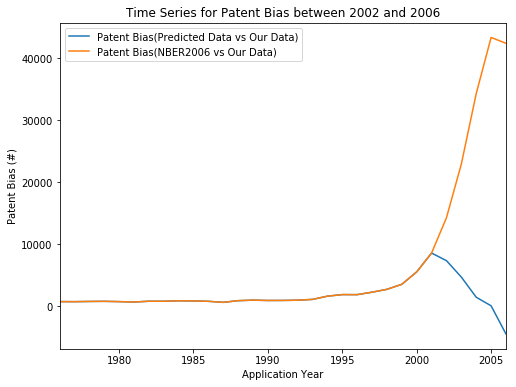

In [38]:
tPlots[["year","Patent Bias(Predicted Data vs Our Data)","Patent Bias(NBER2006 vs Our Data)"]].plot(x="year", figsize=[8,6])
plt.xlabel("Application Year")
plt.ylabel("Patent Bias (#)")
plt.title("Time Series for Patent Bias between 2002 and 2006")
savefig('Pred_Bias_Compare.png')

In [39]:
# Bias_Records = pd.read_stata("regressions/construct bias/final_patent_citation_data.dta")

In [40]:
# Save updated patent file to updated_patent_data.csv for citations prediction
old_outputs = FirmInfo_class_agg_full_save_for_update[FirmInfo_class_agg_full_save_for_update.filed_year<=2001][["gvkey","filed_year","cat_code","wku"]]
MLoutputs.columns = ["gvkey","filed_year","cat_code","wku"]
MLoutputs.loc[MLoutputs.wku<0,"wku"] = 0
Save_data = old_outputs.append(MLoutputs)
Save_data.to_csv("updated_patent_data.csv", index=False)